In [1]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL2/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append('../..') # add standard 's modules
# sys.path.append(wd_path+'/pyfesom/cmocean')
# sys.path.append(wd_path+'/pyfesom/python-gsw')
#########################################

In [2]:
import sys
# sys.path.append(wd_path)
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd
sys.path.append(wd_path+'/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [3]:
# LOAD BATHY AND FLUXES #

ncfile       = '/scratch/usr/hbkoziel/bathy/ETOPO2v2c_f4.nc'
f           = Dataset(ncfile, 'r')
bathy    = f.variables['z'][:,:]
lonbathy    = f.variables['x'][:]
latbathy    = f.variables['y'][:]
Xbat, Ybat = np.meshgrid(lonbathy,latbathy)

In [4]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)             # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'ANPP'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [5]:
time = pd.date_range('1985-01-01', freq="Y", periods= len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = time

In [6]:
ANPP_sel = data.ANPP.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()

ANPP_mean = ANPP_sel.mean(dim='time')
ANPP_mean = ANPP_mean.compute()

ANPP_median = ANPP_sel.median(dim='time')
ANPP_median = ANPP_median.compute()

ANPP_std = ANPP_sel.std(dim='time')
ANPP_std = ANPP_std.compute()

pff = np.polyfit(years, ANPP_sel, 1)
ANPP_trend = pff[0]

In [7]:
data0, elem_no_nan = pf.get_data(ANPP_trend*12.01 / 1000,mesh,0)
data1, elem_no_nan = pf.get_data(ANPP_mean*12.01 / 1000,mesh,0)
data2, elem_no_nan = pf.get_data(ANPP_std*12.01 / 1000,mesh,0)
data3, elem_no_nan = pf.get_data(ANPP_median*12.01 / 1000,mesh,0)

data4 = 100 * data0 / data1

# ind_all = np.load('/home/hbkoziel/pyfesom/codes/DIN_budget/index_all.npy')

# data = np.empty(np.shape(data4))
# data[:] = np.nan
# data[ind_all]=data4[ind_all]

# data2=np.copy(data1)
# data2 = data2 *12.01 / 1000


# data3 = data1 / data0
# data4=np.copy(data3)
# data4 = data4 *100

# data0, elem_no_nan = pf.get_data(ANPP_mean,mesh,0)
# data1, elem_no_nan = pf.get_data(ANPP_trend,mesh,0)
# data2 = data1 / data0

# data2=np.copy(data2)
# data2 = data2 *100

For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used


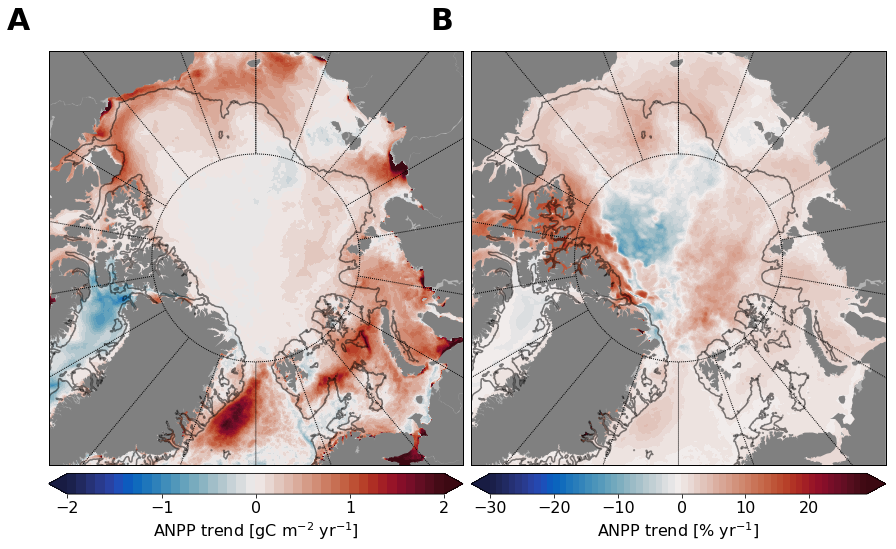

In [13]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

ax1      = fig.add_subplot(121)

contours = np.arange(-2, 2.1, .1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#m.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im=plt.tricontourf(x, y, elem_no_nan, data0, levels=contours, cmap=cmap.cm.balance, extend='both')
xxi, yyi = m(Xbat[:],Ybat[:])
plt.contour(xxi,yyi,-bathy[:],levels = [300], colors='k', alpha = .5)

# plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
#                      fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
label = 'ANPP trend [gC m$^{-2}$ yr$^{-1}$]'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=[-2, -1, 0, 1, 2])
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)




ax2      = fig.add_subplot(122)

contours = np.arange(-30, 30, 1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
#m.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.5')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im=plt.tricontourf(x, y, elem_no_nan, data4, levels=contours, cmap=cmap.cm.balance, extend='both')
plt.contour(xxi,yyi,-bathy[:],levels = [300], colors='k', alpha = .5)
# plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
#                      fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
label = 'ANPP trend [% yr$^{-1}$]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(-30,31,10))
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes,
            size=30, weight='bold')
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes,
            size=30, weight='bold')

fig.subplots_adjust(wspace=0.02,hspace=0.12)
plt.savefig(save_path+'FIG4.png', dpi = 300, bbox_inches='tight') 